In [1]:
from mne.datasets import multimodal
import mne
mne.set_log_level(verbose='CRITICAL')
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
from deepmeg.training.callbacks import Callback, EarlyStopping, L2Reg
from deepmeg.training.trainers import Trainer
from deepmeg.data.datasets import read_epochs_dataset, EpochsDataset
from deepmeg.preprocessing.transforms import zscore
from deepmeg.models import BaseModel
import torch
import torch.nn as nn
from collections import defaultdict
from deepmeg.data.utils import make_train_and_val_loaders
from torch.utils.data import DataLoader, Dataset
import torchmetrics
from deepmeg.training.callbacks import PrintingCallback
from deepmeg.models.interpretable import SPIRIT, LFCNN, TimeCompNet
from deepmeg.data.datasets import read_epochs_dataset, EpochsDataset
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# very simple function to plot history of the model training

def plot_metrics(metrics: dict[str, np.ndarray]):
    plot_dict = defaultdict(dict)

    for metric, values in metrics.items():
        metric_data = metric.split('_')
        metric_name = '_'.join(metric_data[:-1])
        metric_kind = metric_data[-1]
        plot_dict[metric_name][metric_kind] = values

    for metric_name, kind_dict in plot_dict.items():
        legend = list()
        for metric_kind, kind in kind_dict.items():
            plt.plot(kind)
            legend.append(metric_kind)
        plt.title(metric_name)
        plt.legend(legend)
        plt.show()

In [4]:
fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')
raw = mne.io.read_raw_fif(fname_raw)

cond = raw.acqparser.get_condition(raw, None)

for c in cond:
    c['tmin'] = -.2
    c['tmax'] = 1.

# get the list of condition names
condition_names = [k for c in cond for k,v in c['event_id'].items()]
epochs_list = [mne.Epochs(raw, **c) for c in cond]
epochs = mne.concatenate_epochs(epochs_list)
epochs.pick_types(meg='grad')
epochs_original = epochs.copy()


/home/user/Projects/deepmeg/venv/lib/python3.10/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


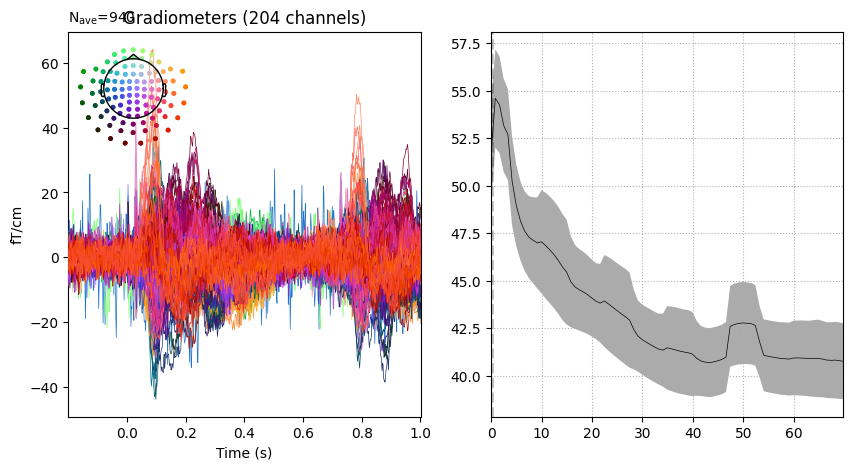

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
epochs.plot_psd(average=True, ax=ax2, fmax=70)
epochs.average().plot(axes=ax1)
plt.show()

In [88]:
dataset.save('../data/multimodal.pt')

In [3]:
dataset = read_epochs_dataset('../data/multimodal_1s.pt')

In [4]:
X.shape

NameError: name 'X' is not defined

In [34]:
epochs = epochs_original.copy()
epochs.resample(207).apply_baseline((None, 0))
epochs.crop(0, None)
dataset = EpochsDataset(
    epochs,
    savepath='../datasets/multimodal',
    transform=zscore
)
train, test = torch.utils.data.random_split(dataset, [.7, .3])
X, y = next(iter(DataLoader(test)))

model_kwargs = dict(
    n_channels=204,
    n_latent=8,
    n_times=X.shape[-1],
    filter_size=50,
    pool_factor=10,
    n_outputs=8
)

LFCNN(
    **model_kwargs
)(X)

tensor([[-0.0519, -0.2530, -0.1861,  0.1428, -0.0107, -0.0064, -0.2031,  0.0190]],
       grad_fn=<AddmmBackward0>)

In [ ]:
dataset = EpochsDataset(
    epochs,
    savepath='../datasets/multimodal',
    transform=zscore
)

In [5]:
train, test = torch.utils.data.random_split(dataset, [.7, .3])

In [6]:
X, y = next(iter(DataLoader(train)))

In [28]:
model_kwargs = dict(
    n_channels=204,
    n_latent=8,
    n_times=X.shape[-1],
    filter_size=50,
    pool_factor=10,
    n_outputs=8
)

In [29]:
# from deepmeg.models.interpretable import LFCNN

model = LFCNN(
    **model_kwargs
)

optimizer = torch.optim.Adam
loss = torch.nn.BCEWithLogitsLoss()
metric = torchmetrics.functional.classification.binary_accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        L2Reg(
            [
                'unmixing_layer.weight', 'temp_conv.weight',
            ], lambdas=.01
        ) # l2 regularization for weights of spatial- and temporal filtering layers
    ]
)

Epoch 0:  loss_train:  0.7208   |    binary_accuracy_train:  0.5383   |    loss_val:  0.6998   |    binary_accuracy_val:  0.6284
Epoch 1:  loss_train:  0.6782   |    binary_accuracy_train:  0.6988   |    loss_val:  0.6642   |    binary_accuracy_val:  0.7274
Epoch 2:  loss_train:  0.6347   |    binary_accuracy_train:  0.8000   |    loss_val:  0.6274   |    binary_accuracy_val:  0.7830
Epoch 3:  loss_train:  0.5885   |    binary_accuracy_train:  0.8370   |    loss_val:  0.5908   |    binary_accuracy_val:  0.7953
Epoch 4:  loss_train:  0.5426   |    binary_accuracy_train:  0.8472   |    loss_val:  0.5578   |    binary_accuracy_val:  0.7927
Epoch 5:  loss_train:  0.5019   |    binary_accuracy_train:  0.8483   |    loss_val:  0.5318   |    binary_accuracy_val:  0.7979
Epoch 6:  loss_train:  0.4707   |    binary_accuracy_train:  0.8525   |    loss_val:  0.5113   |    binary_accuracy_val:  0.8144
Epoch 7:  loss_train:  0.4471   |    binary_accuracy_train:  0.8612   |    loss_val:  0.4909   | 

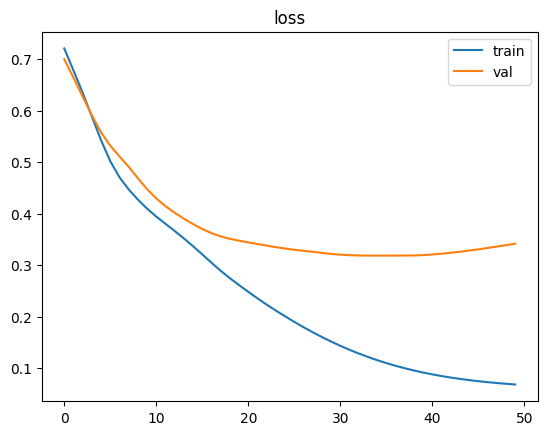

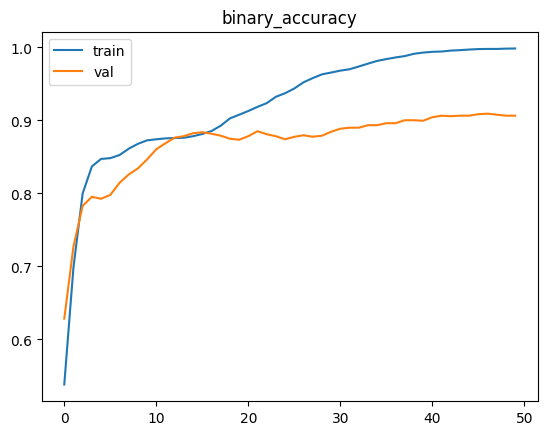

In [30]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [33]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.16103344749320636
train_binary_accuracy: 0.9623907425186851
loss: 0.3536750471050089
binary_accuracy: 0.8810876607894897


In [38]:
info = epochs.info

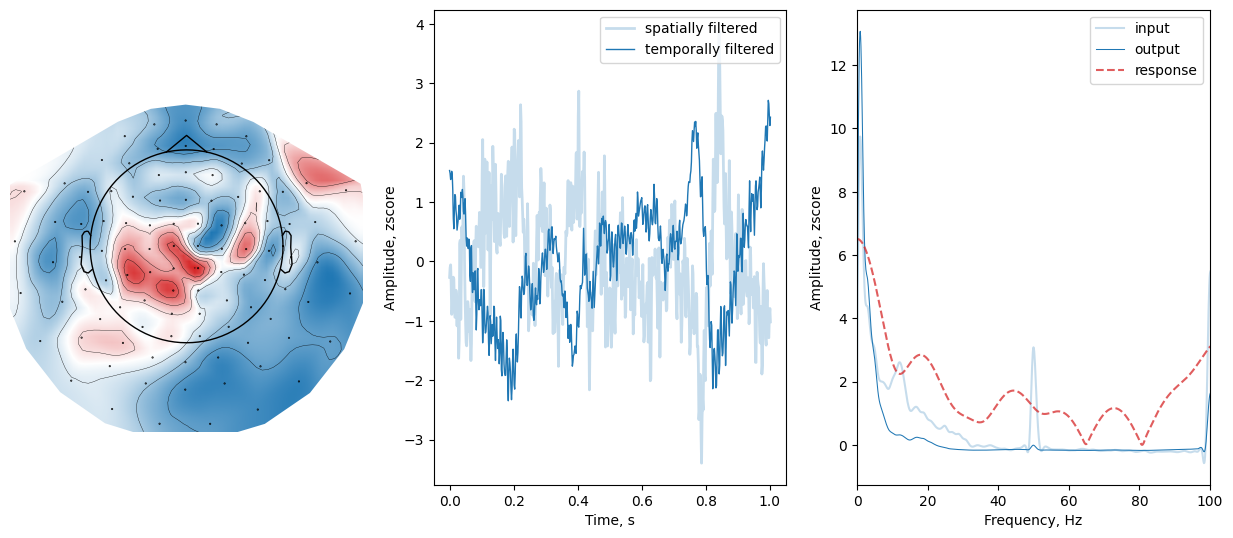

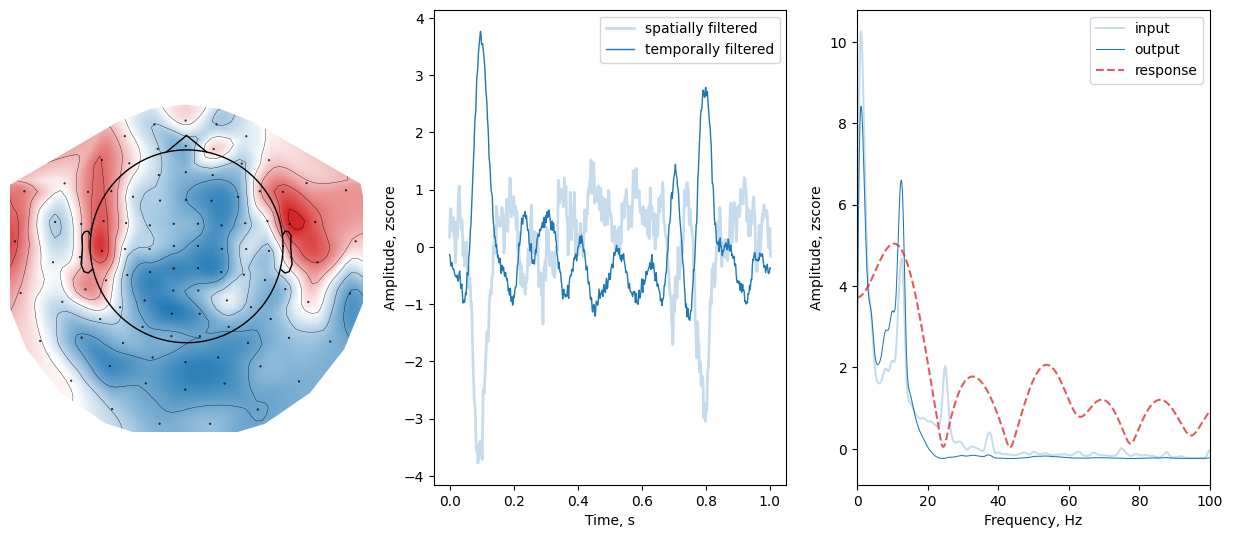

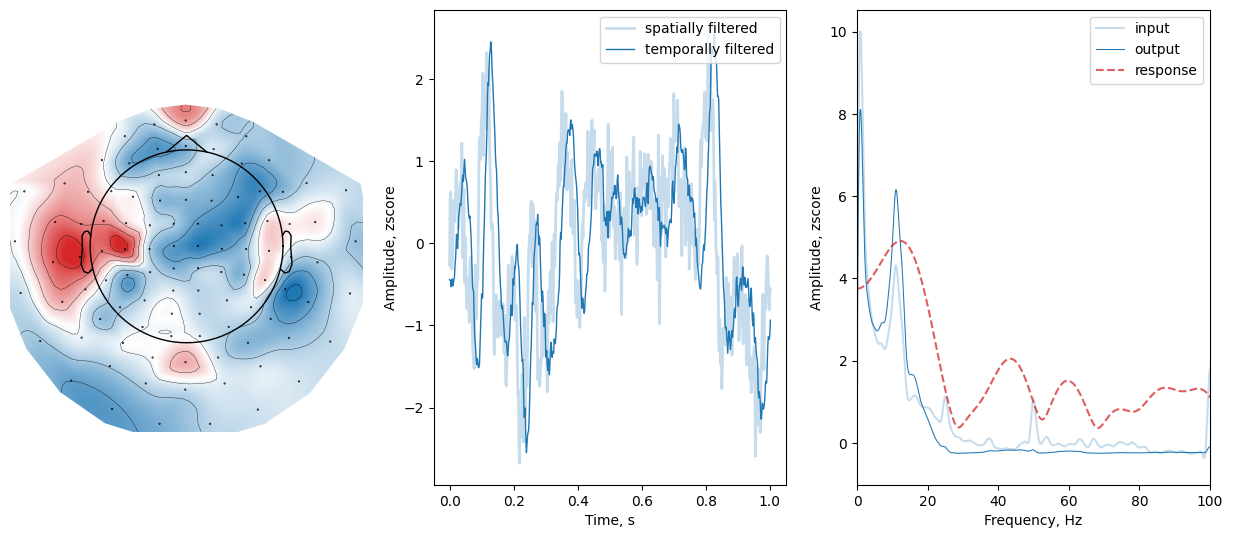

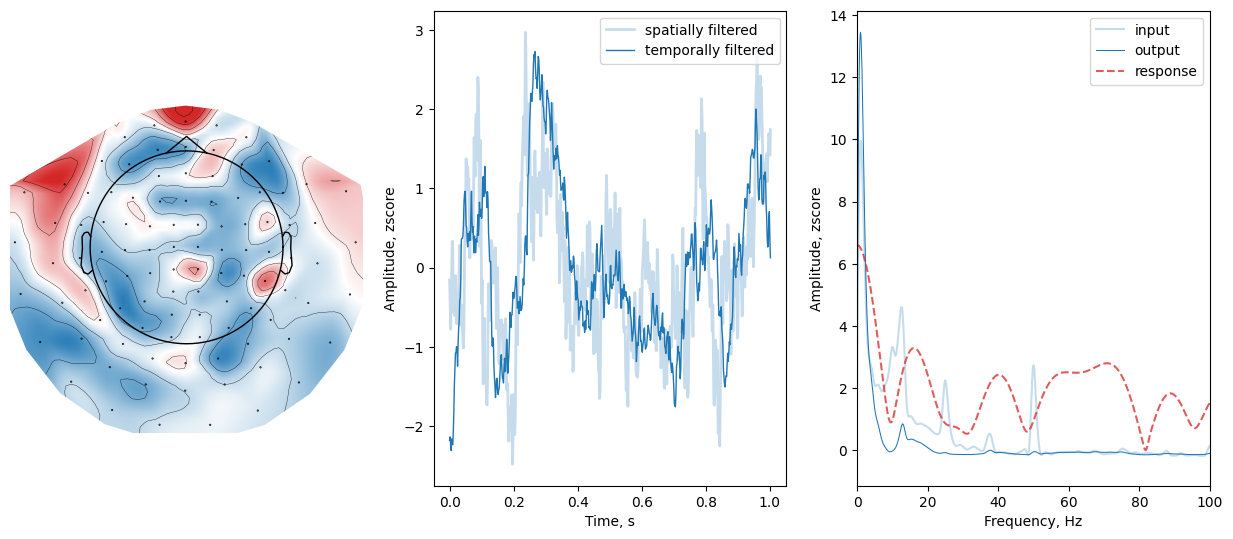

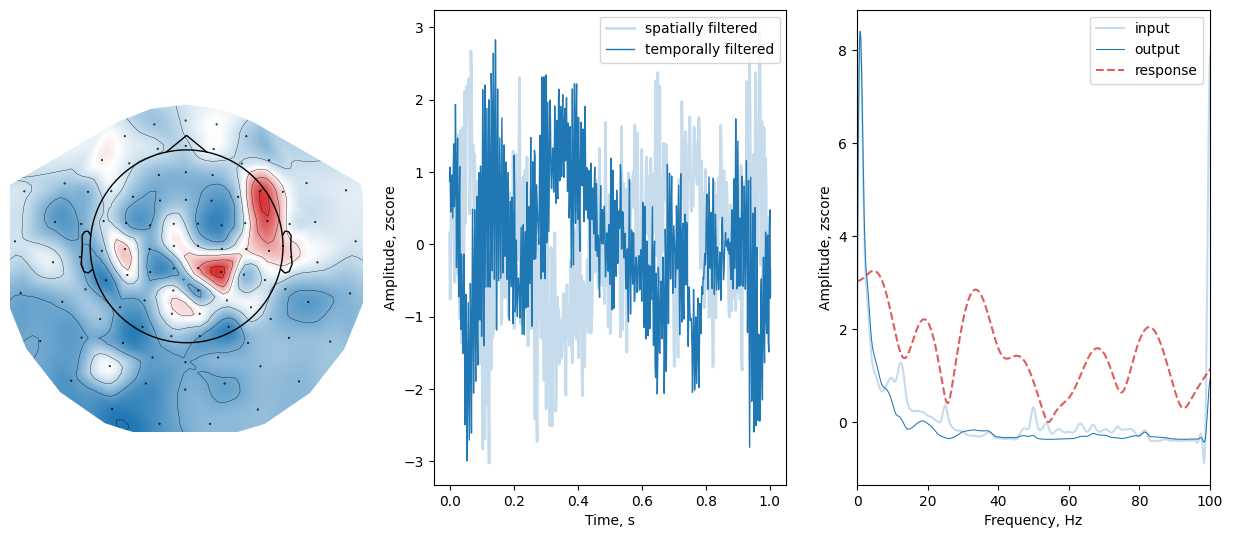

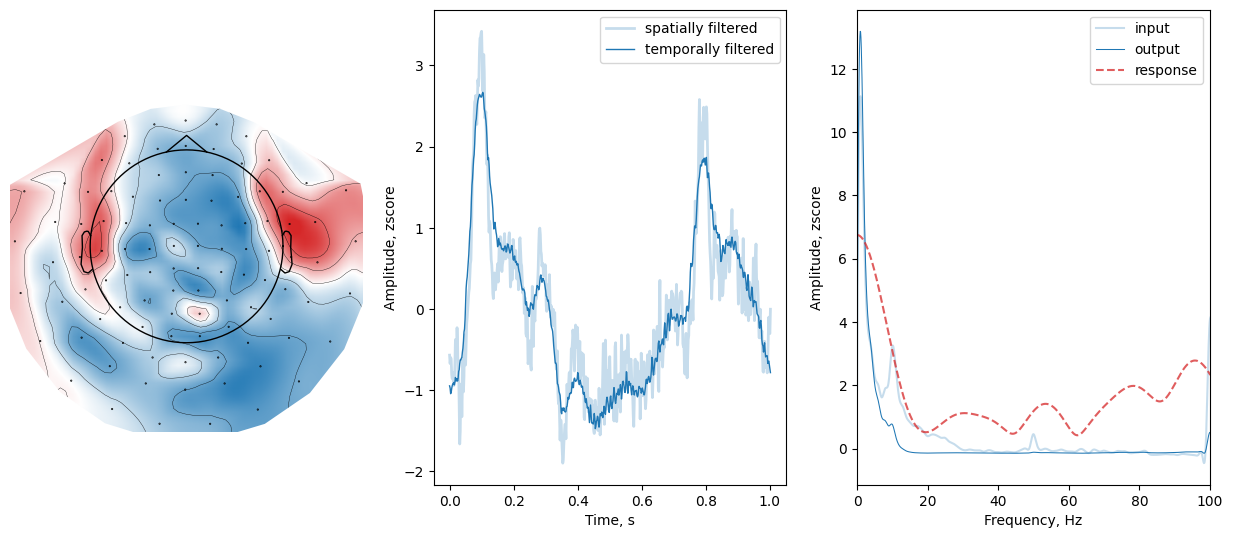

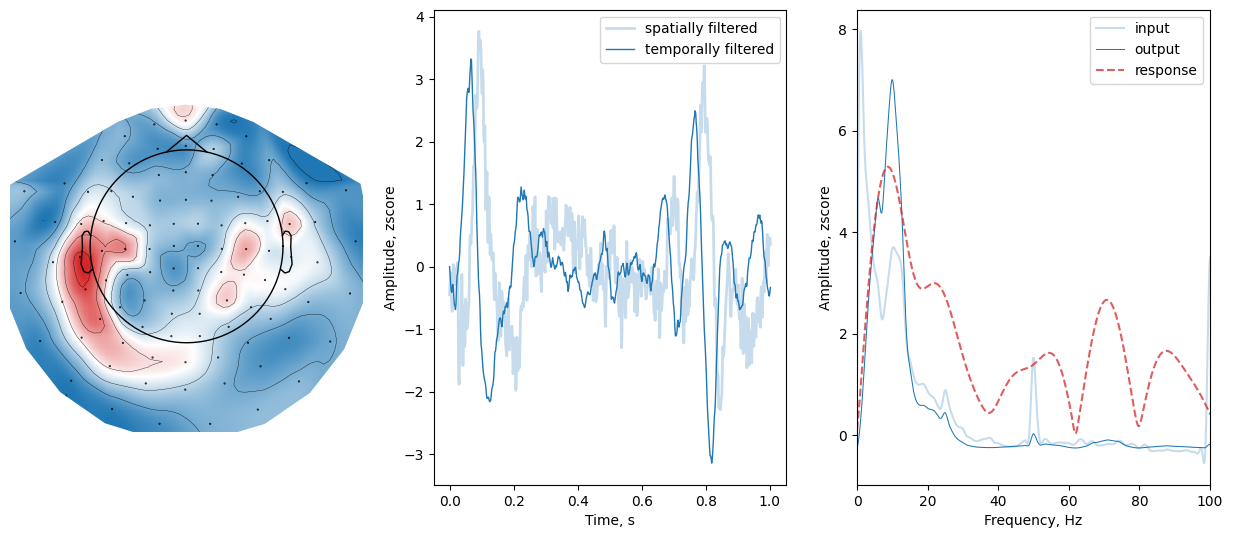

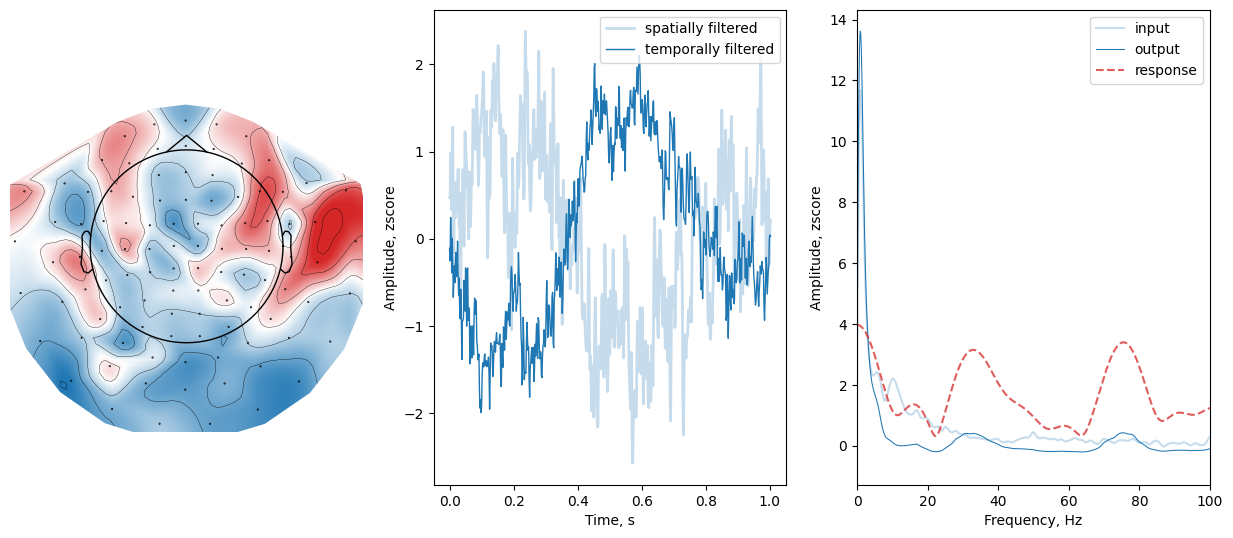

In [34]:
from deepmeg.interpreters import LFCNNInterpreter

interpreter = LFCNNInterpreter(model, test, info)
for branch in range(8):
    fig = interpreter.plot_branch(branch)
    plt.show()

In [35]:
model_kwargs = dict(
    n_channels=204,
    n_latent=8,
    n_times=X.shape[-1],
    filter_size=50,
    window_size=10,
    latent_dim=10,
    pool_factor=10,
    n_outputs=8
)

In [36]:
SPIRIT(
    **model_kwargs
)(X)

tensor([[-0.1863, -0.1512, -0.2111,  0.6060,  0.1436, -0.3137, -0.1087, -0.4794]],
       grad_fn=<AddmmBackward0>)

In [59]:
model = SPIRIT(
    **model_kwargs
)

optimizer = torch.optim.Adam
loss = torch.nn.BCEWithLogitsLoss()
metric = torchmetrics.functional.classification.binary_accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        L2Reg(
            [
                'unmixing_layer.weight', 'temp_conv.weight',
                *[f'timesel_list.{i}.0.weight' for i in range(8)],
                *[f'timecomp_list.{i}.0.weight' for i in range(8)],
            ], lambdas=[
                .01, .01,
                *[.001 for _ in range(8)],
                *[.001 for _ in range(8)]
            ]
            # lambdas=.01
        ) # l2 regularization for weights of spatial- and temporal filtering layers
    ]
)

Epoch 0:  loss_train:  0.6748   |    binary_accuracy_train:  0.7167   |    loss_val:  0.5500   |    binary_accuracy_val:  0.8750
Epoch 1:  loss_train:  0.5202   |    binary_accuracy_train:  0.8750   |    loss_val:  0.4706   |    binary_accuracy_val:  0.8750
Epoch 2:  loss_train:  0.4662   |    binary_accuracy_train:  0.8750   |    loss_val:  0.4591   |    binary_accuracy_val:  0.8750
Epoch 3:  loss_train:  0.4613   |    binary_accuracy_train:  0.8750   |    loss_val:  0.4692   |    binary_accuracy_val:  0.8750
Epoch 4:  loss_train:  0.4671   |    binary_accuracy_train:  0.8750   |    loss_val:  0.4759   |    binary_accuracy_val:  0.8750
Epoch 5:  loss_train:  0.4658   |    binary_accuracy_train:  0.8750   |    loss_val:  0.4737   |    binary_accuracy_val:  0.8750
Epoch 6:  loss_train:  0.4564   |    binary_accuracy_train:  0.8750   |    loss_val:  0.4657   |    binary_accuracy_val:  0.8750
Epoch 7:  loss_train:  0.4419   |    binary_accuracy_train:  0.8750   |    loss_val:  0.4554   | 

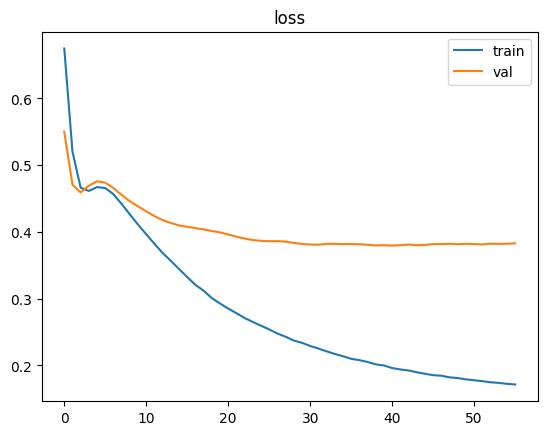

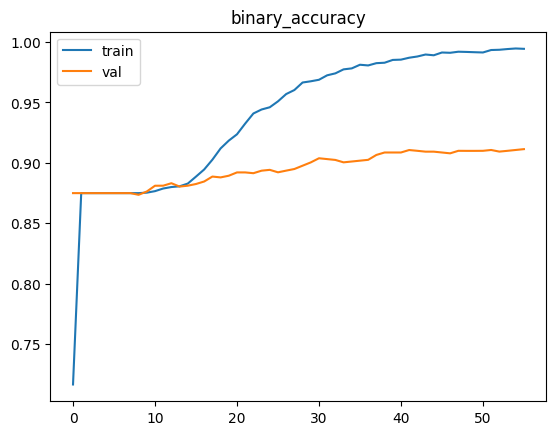

In [60]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [61]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.22704884138974277
train_binary_accuracy: 0.9712412574074485
loss: 0.36160025813362817
binary_accuracy: 0.8969155875119296


In [20]:
from mne.datasets import multimodal
fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')

info = mne.io.read_raw_fif(fname_raw).pick_types(meg='grad').info

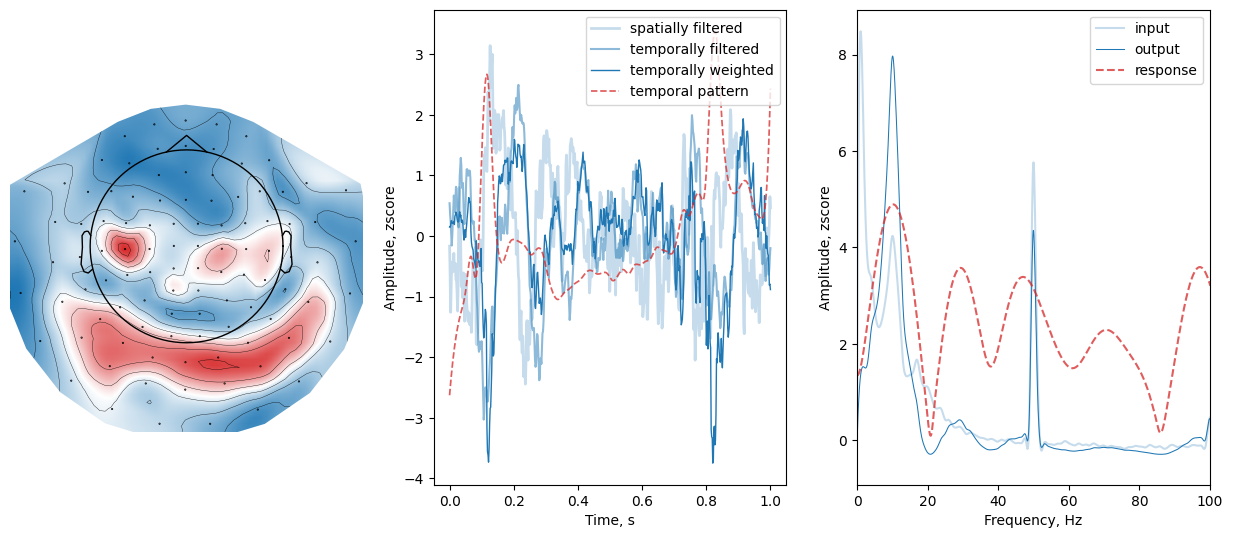

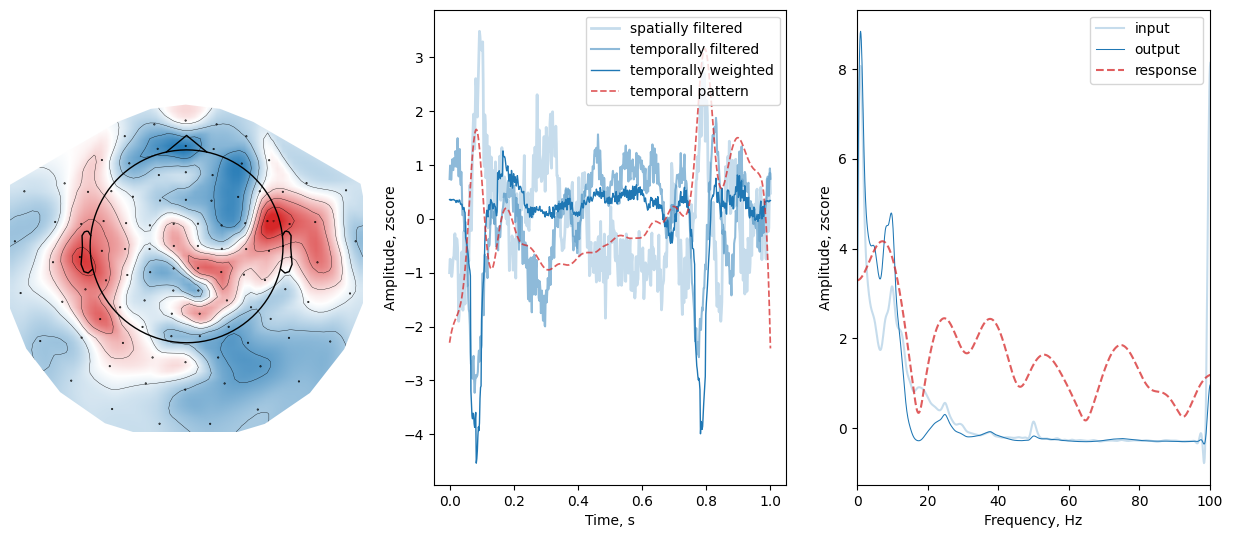

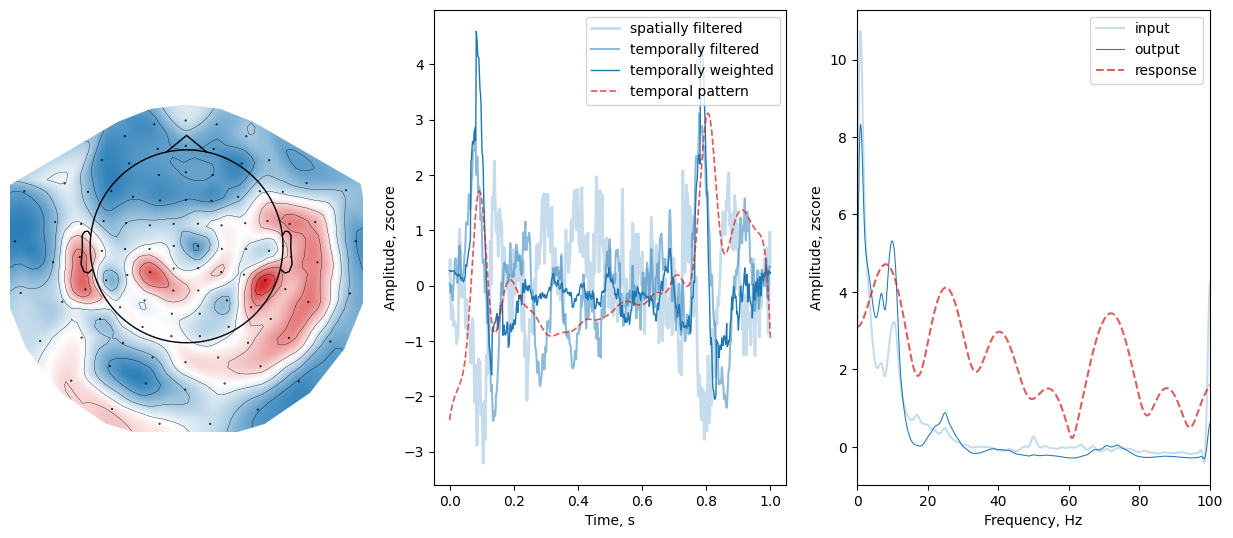

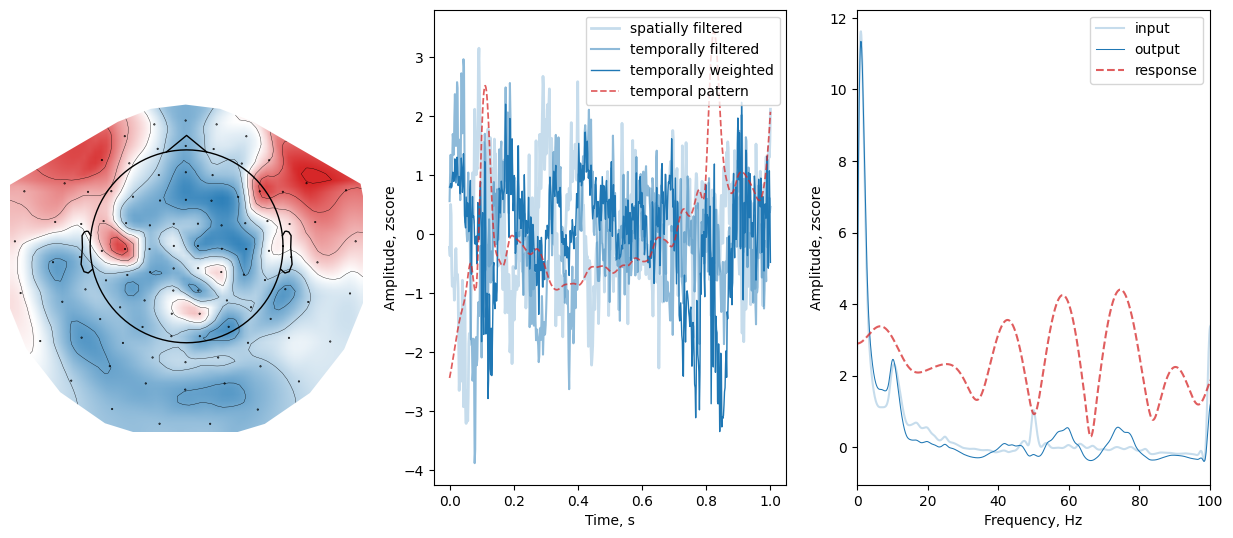

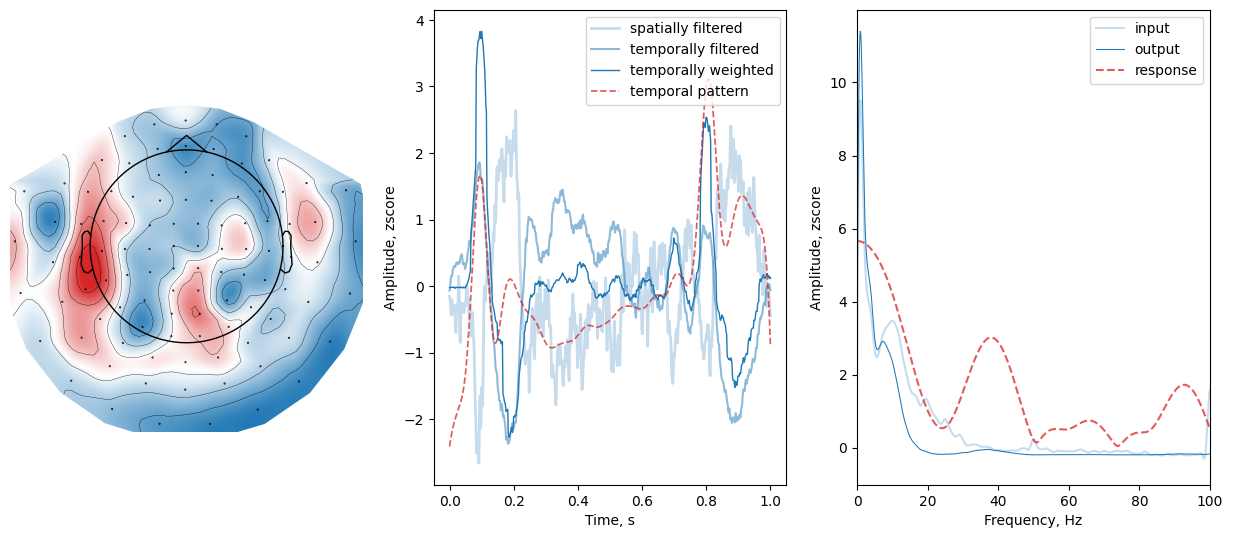

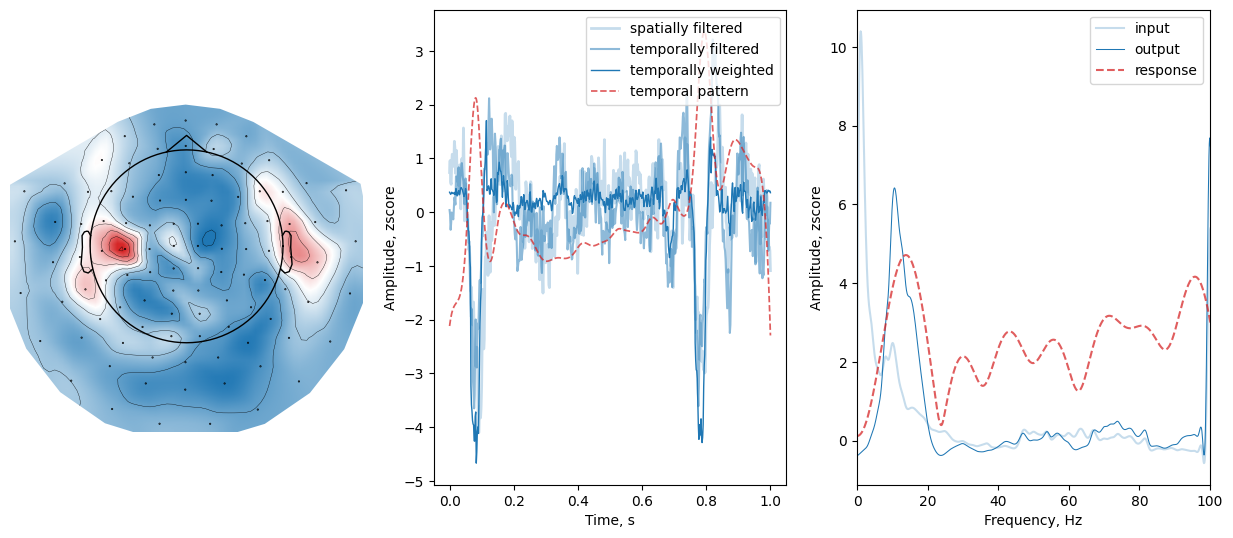

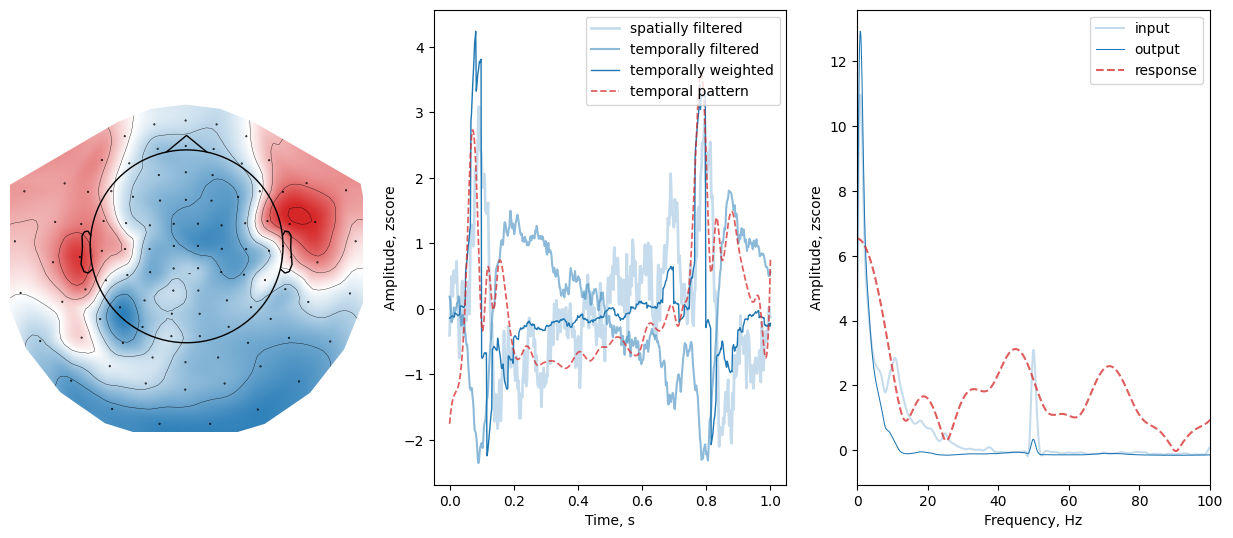

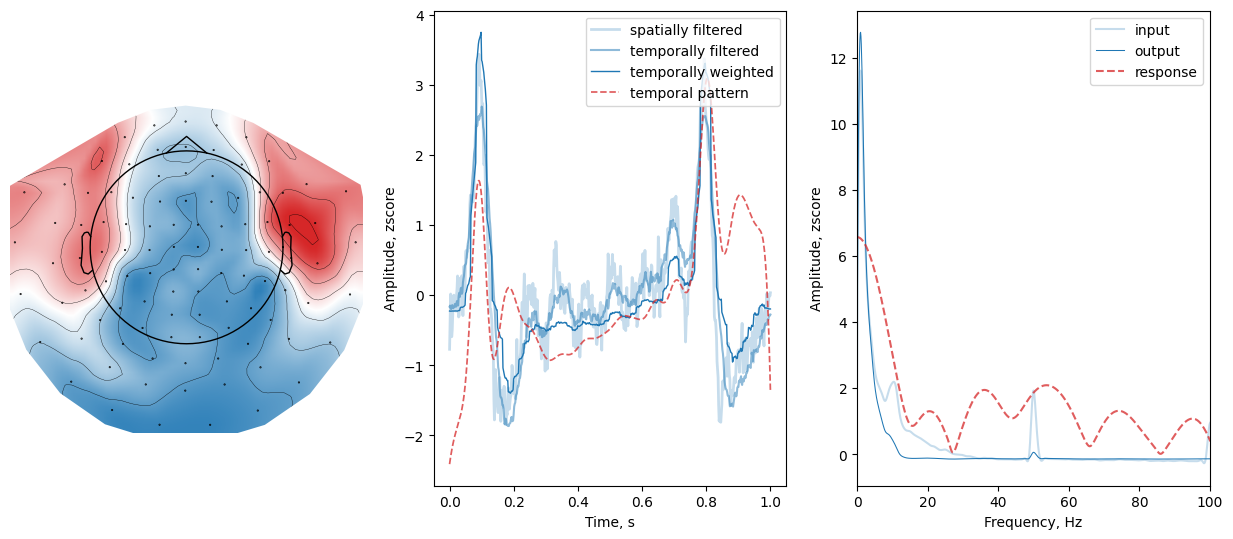

In [62]:
from deepmeg.interpreters import SPIRITInterpreter

interpreter = SPIRITInterpreter(model, test, info)
for branch in range(8):
    fig = interpreter.plot_branch(branch)
    plt.show()

In [22]:
model = TimeCompNet(
    n_channels=204, # ~ number of channels (gradiometers)
    n_latent=8, # ~ number of latent factors
    n_times=X.shape[-1], # ~ number of samples in epoch after preprocessing
    filter_size=50, # ~ FIR filter size
    pool_factor=10, # ~ take each 10th sample from spatially filtered components
    n_outputs=8 # ~ number of output classes (number of events in epochs)
)

optimizer = torch.optim.Adam
loss = torch.nn.BCEWithLogitsLoss()
metric = torchmetrics.functional.classification.binary_accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        L2Reg(
            [
                'unmixing_layer.weight', 'temp_conv.weight',
                *[f'timesel_list.{i}.0.weight' for i in range(8)],
            ], lambdas=[.01, .01, *[1e-3 for _ in range(8)]]
        ) # l2 regularization for weights of spatial- and temporal filtering layers
    ]
)

Epoch 0:  loss_train:  0.7070   |    binary_accuracy_train:  0.6846   |    loss_val:  0.5612   |    binary_accuracy_val:  0.8661
Epoch 1:  loss_train:  0.5170   |    binary_accuracy_train:  0.8731   |    loss_val:  0.4643   |    binary_accuracy_val:  0.8750
Epoch 2:  loss_train:  0.4484   |    binary_accuracy_train:  0.8750   |    loss_val:  0.4465   |    binary_accuracy_val:  0.8750
Epoch 3:  loss_train:  0.4383   |    binary_accuracy_train:  0.8750   |    loss_val:  0.4527   |    binary_accuracy_val:  0.8750
Epoch 4:  loss_train:  0.4396   |    binary_accuracy_train:  0.8750   |    loss_val:  0.4558   |    binary_accuracy_val:  0.8750
Epoch 5:  loss_train:  0.4338   |    binary_accuracy_train:  0.8750   |    loss_val:  0.4504   |    binary_accuracy_val:  0.8750
Epoch 6:  loss_train:  0.4192   |    binary_accuracy_train:  0.8750   |    loss_val:  0.4389   |    binary_accuracy_val:  0.8750
Epoch 7:  loss_train:  0.4001   |    binary_accuracy_train:  0.8750   |    loss_val:  0.4253   | 

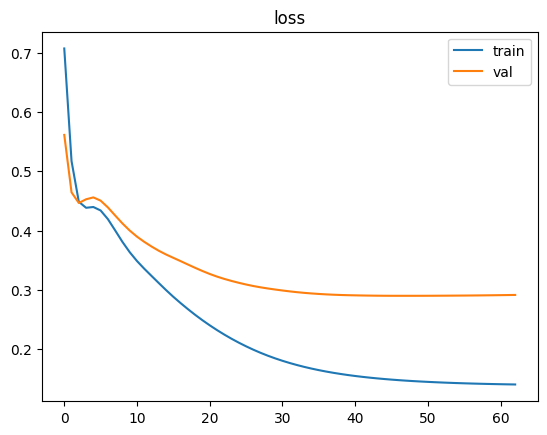

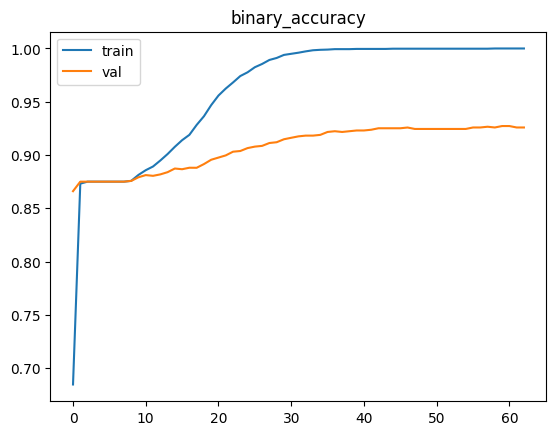

In [24]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [25]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.18186625431884418
train_binary_accuracy: 0.9814248247580095
loss: 0.31176205385815015
binary_accuracy: 0.9139610420573842


Estimating temporal compression weights, it will take some time
9it [26:14, 196.80s/it]                       


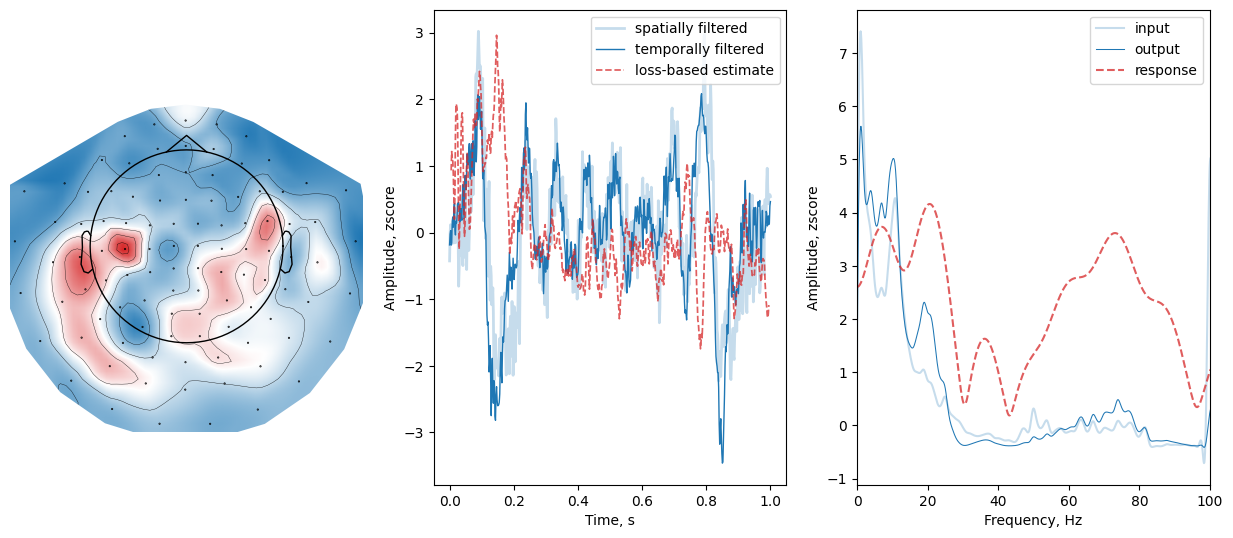

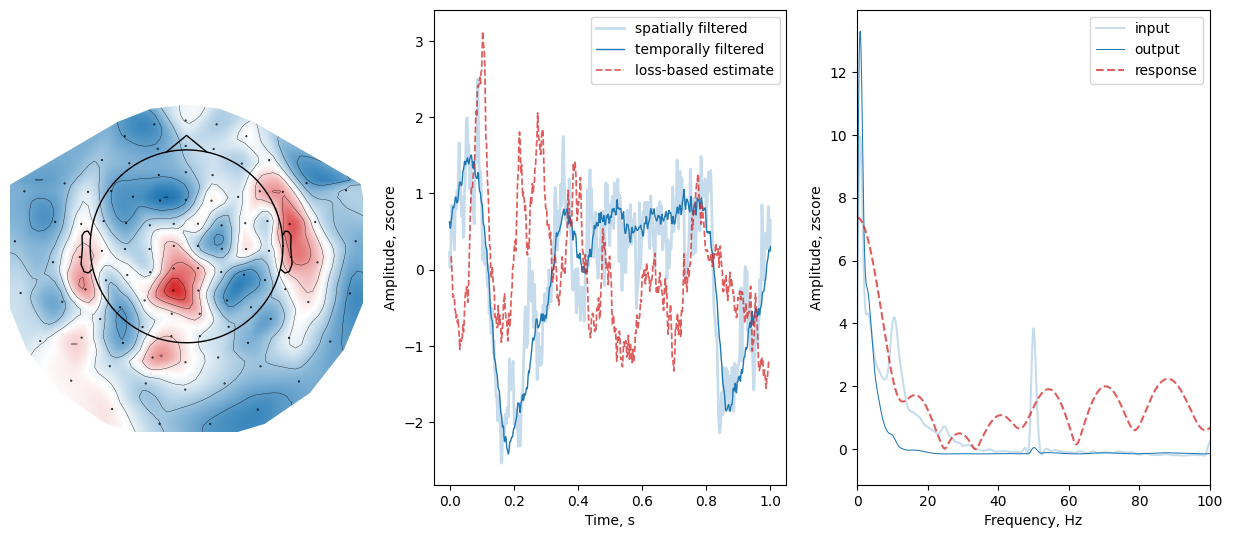

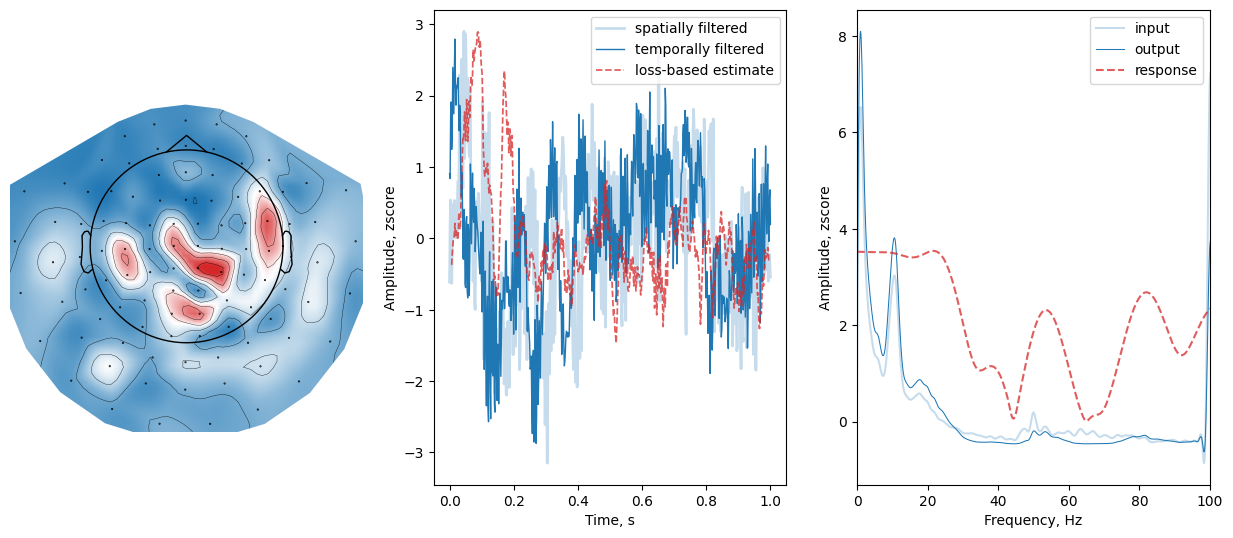

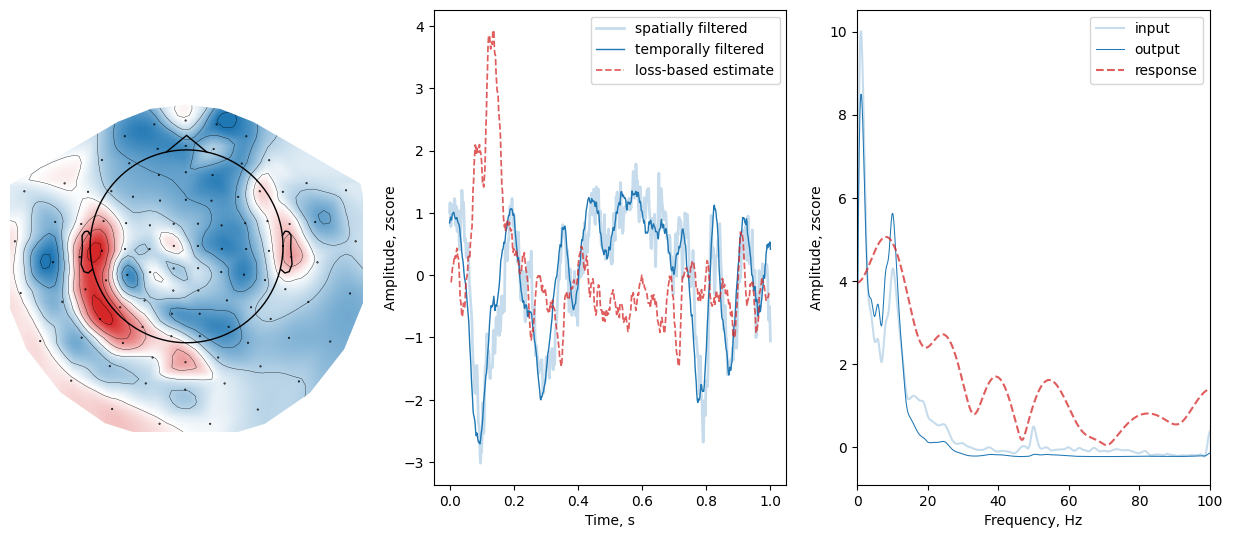

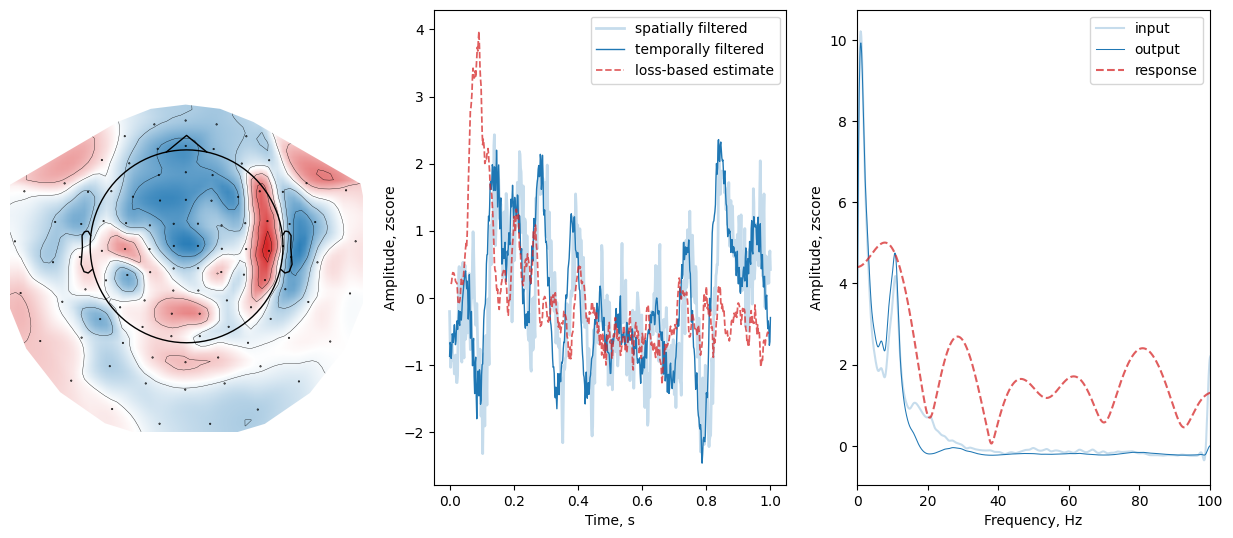

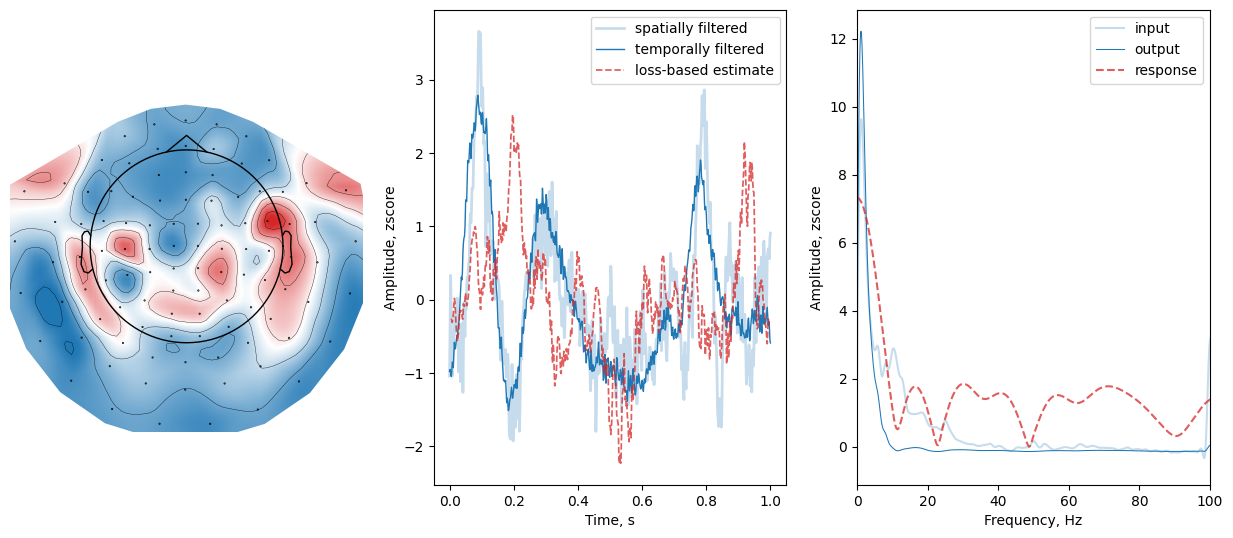

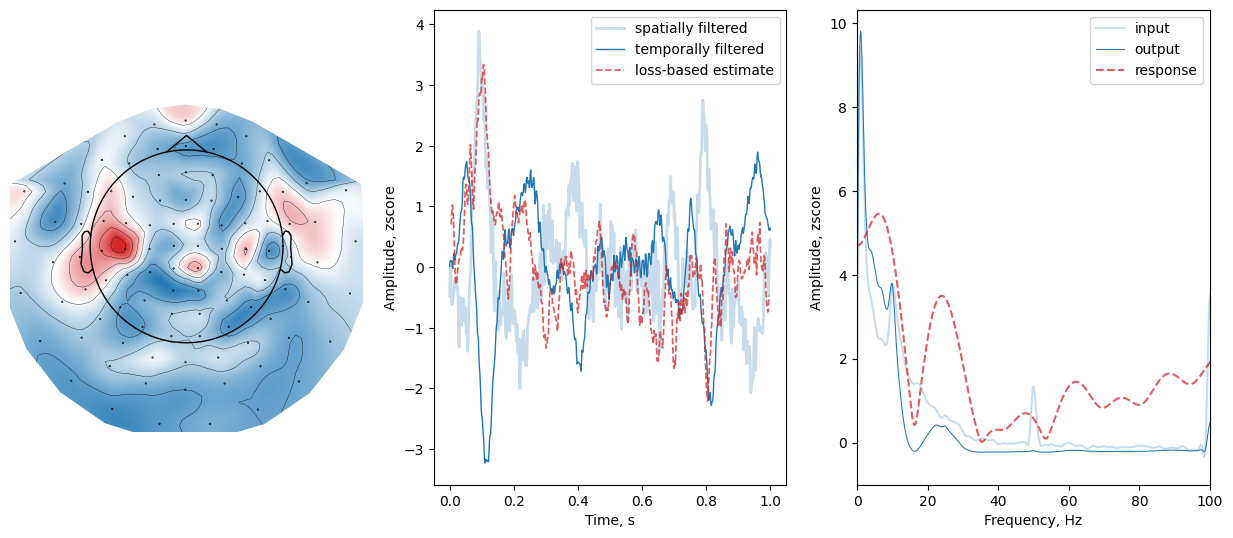

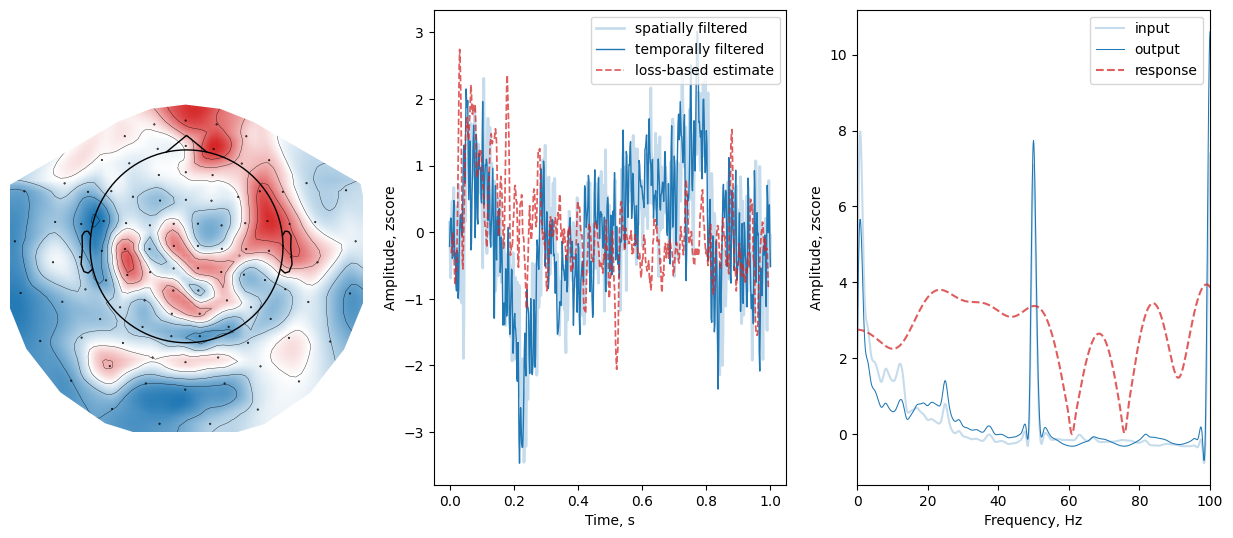

In [26]:
from deepmeg.interpreters import TimeCompNetInterpreter

interpreter = TimeCompNetInterpreter(model, test, info)
for branch in range(8):
    fig = interpreter.plot_branch(branch)
    plt.show()